This notebook computes and analyzes performance metrics from the raw results generated by `eval_ultra.py` and `baseline.py`. It reproduces Tables 1 and 2 from the paper and provides additional figures highlighting the key takeaways of our experiments.

In [1]:
import gzip
import json
import os

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import average_precision_score, roc_auc_score

In [2]:
COLORS = ['tab:blue', 'tab:orange']
LINESTYLES = ['--', '-.', ':']
DATASETS = {'lanl': 'LANL', 'optc': 'OpTC'}

First of all, we read the results and compute the AUC and average precision for each experiment. The raw experiment results provided in the `results/` directory are used here. Alternatively, you can change the path to the results to analyze your own experiments.

In [3]:
res = {}
res_summary = {}
for dataset in os.listdir('results/'):
    res[dataset] = {}
    res_summary[dataset] = {}
    for fname in os.listdir(os.path.join('results', dataset)):
        fp = os.path.join('results', dataset, fname)
        if fp.endswith('.gz'):
            with gzip.open(fp, 'rt') as file:
                dat = json.loads(file.read())
        else:
            with open(fp) as file:
                dat = json.loads(file.read())
        y_true, y_pred = dat['labels'], dat['scores']
        if dat['model'] in ('HPF', 'PTF'):
            key = dat['model']
        else:
            if dat['finetuning_dataset'].endswith('Rich'):
                dat['finetuning_dataset'] = dat['finetuning_dataset'][:-4]
            if dat['model'].startswith('ultra'):
                if dat['finetuning_dataset'] != 'none':
                    key = f"{dat['model']} ({dat['finetuning_dataset']})"
                else:
                    key = dat['model']
            else:
                key = f"Ultra ({dat['finetuning_dataset']})"
        if key not in res[dataset]:
            res[dataset][key] = {'auc': [], 'ap': []}
            res_summary[dataset][key] = {}
        res[dataset][key]['ap'].append(average_precision_score(y_true, y_pred))
        res[dataset][key]['auc'].append(roc_auc_score(y_true, y_pred))
    for key in res[dataset]:
        ap, auc = np.array(res[dataset][key]['ap']), np.array(res[dataset][key]['auc'])
        res_summary[dataset][key]['ap'] = (100 * ap.mean(), 100 * ap.std())
        res_summary[dataset][key]['auc'] = (100 * auc.mean(), 100 * auc.std())

The cell below reproduces Tables 1 and 2 from the paper, which report the average and standard deviation of each metric for each dataset (LANL and OpTC) and model (baselines, pre-trained and fine-tuned Ultra models, Ultra models trained from scratch).

In [4]:
for dataset in ('lanl', 'optc'):
    max_len = max(len(k) for k in res[dataset])
    print(DATASETS[dataset] + ' ' * (max_len - len(dataset)) + '\tAUC (basic)\tAP (basic)\tAUC (rich)\tAP (rich)')
    print('-' * len(dataset) + ' ' * (max_len - len(dataset)) + '\t-----------\t----------\t----------\t---------')
    for model in sorted(list(res[dataset].keys())):
        print(f"{model + ' ' * (max_len - len(model))}"
              f"\t{res_summary[dataset][model]['auc'][0]:.1f} ({res_summary[dataset][model]['auc'][1]:.1f})"
              f"\t{res_summary[dataset][model]['ap'][0]:.1f} ({res_summary[dataset][model]['ap'][1]:.1f})"
              f"\t{res_summary[dataset + '-rich'][model]['auc'][0]:.1f} ({res_summary[dataset + '-rich'][model]['auc'][1]:.1f})"
              f"\t{res_summary[dataset + '-rich'][model]['ap'][0]:.1f} ({res_summary[dataset + '-rich'][model]['ap'][1]:.1f})"
        )
    print('\n')

LANL            	AUC (basic)	AP (basic)	AUC (rich)	AP (rich)
----            	-----------	----------	----------	---------
HPF             	92.3 (0.4)	16.0 (2.7)	91.3 (0.7)	10.7 (0.7)
PTF             	90.4 (2.6)	3.8 (1.6)	88.1 (2.9)	3.1 (1.3)
Ultra (LANL)    	80.7 (4.0)	3.4 (3.1)	82.8 (9.2)	5.0 (7.0)
Ultra (OpTC)    	75.4 (8.7)	2.6 (3.8)	74.6 (12.5)	1.1 (0.3)
ultra_3g        	88.4 (0.0)	2.2 (0.0)	90.8 (0.0)	5.7 (0.0)
ultra_3g (LANL) 	89.9 (1.8)	11.6 (6.3)	81.6 (1.7)	1.5 (0.2)
ultra_3g (OpTC) 	87.9 (3.7)	11.8 (6.6)	94.1 (2.4)	12.3 (3.9)
ultra_4g        	98.4 (0.0)	25.6 (0.0)	94.4 (0.0)	17.6 (0.0)
ultra_4g (LANL) 	92.5 (1.3)	14.2 (7.7)	86.3 (4.3)	4.6 (3.7)
ultra_4g (OpTC) 	91.5 (1.4)	12.4 (5.8)	96.9 (0.9)	18.2 (4.4)
ultra_50g       	88.0 (0.0)	2.9 (0.0)	90.9 (0.0)	26.4 (0.0)
ultra_50g (LANL)	88.8 (2.5)	7.7 (6.5)	84.5 (3.2)	2.9 (2.0)
ultra_50g (OpTC)	91.1 (3.6)	14.1 (10.0)	90.0 (2.3)	8.4 (4.9)


OpTC            	AUC (basic)	AP (basic)	AUC (rich)	AP (rich)
----            	-----------	-----

Now, let's dive deeper. First of all, we compare the zero-shot performance of the pre-trained Ultra models with the performance of the two baseline models, HPF and PTF. For each dataset and metric, we display the performance of each model for both the basic and enriched knowledge graph representations of the data. The results are deterministic for the pre-trained models, thus we display them as simple horizontal lines. As for the baselines, their performance depends on the random initialization of their inference procedure, and we display the results of 10 runs as box plots.

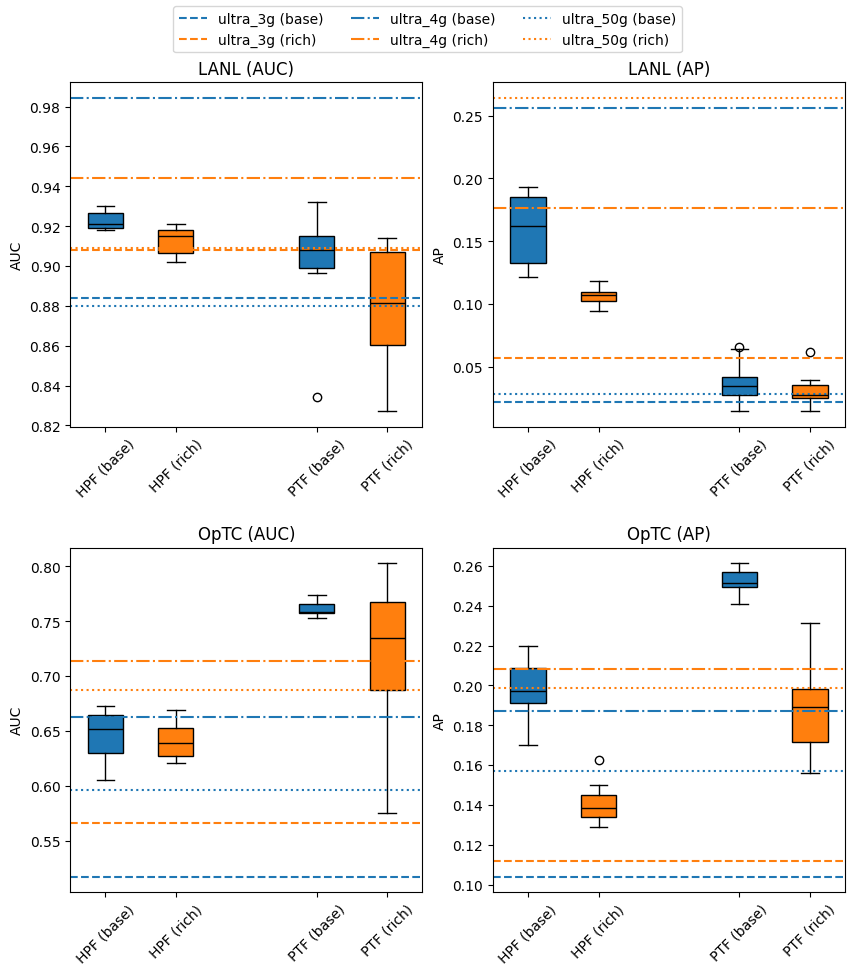

In [5]:
fig, axes = plt.subplots(2, 2)
for row, dataset in enumerate(['lanl', 'optc']):
    for metric, ax in zip(['auc', 'ap'], axes[row]):
        bplot = ax.boxplot(
            [
                res[dataset]['HPF'][metric],
                res[dataset + '-rich']['HPF'][metric],
                res[dataset]['PTF'][metric],
                res[dataset + '-rich']['PTF'][metric]
            ],
            positions=[1, 2, 4, 5],
            labels=['HPF (base)', 'HPF (rich)', 'PTF (base)', 'PTF (rich)'],
            patch_artist=True
        )
        for patch, color in zip(bplot['boxes'], COLORS[:2] * 2):
            patch.set_facecolor(color)
        for line in bplot['medians']:
            line.set_color('black')
        for model, ls in zip(['ultra_3g', 'ultra_4g', 'ultra_50g'], LINESTYLES[:3]):
            ax.hlines(
                res[dataset][model][metric][0],
                .5, 5.5,
                color=COLORS[0], ls=ls,
                label=f"{model} (base)"
            )
            ax.hlines(
                res[dataset + '-rich'][model][metric][0],
                .5, 5.5,
                color=COLORS[1], ls=ls,
                label=f"{model} (rich)"
            )
        ax.set_title(f"{DATASETS[dataset]} ({metric.upper()})")
        ax.set_ylabel(f"{metric.upper()}")
        ax.tick_params(axis='x', labelrotation=45)
        handles, labels = ax.get_legend_handles_labels()
plt.subplots_adjust(top=.92, hspace=.35)
fig.legend(handles, labels, ncol=3, loc='upper center')
fig.set_size_inches(10, 10)

Overall, the pre-trained models achieve competitive performance. In particular, Ultra4g and Ultra50g outperform both baselines on the LANL dataset and come in second (behind PTF) on the OpTC dataset.

Next, let's zoom in on the zero-shot performance of the pre-trained models. The most obvious question is whether some models are better than others. Another interesting aspect is the influence of the representation of the data: does the enriched representation yield better results? To answer these questions, we display the performance of each pre-trained model using both representations, for each dataset and metric.

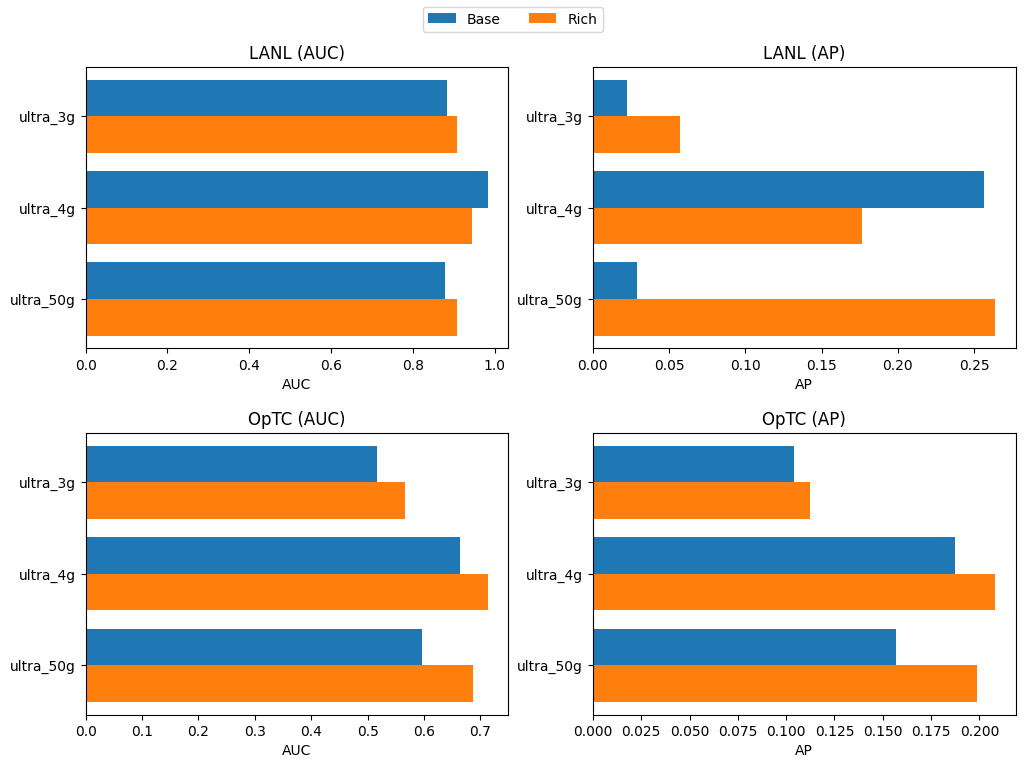

In [6]:
fig, axes = plt.subplots(2, 2)
models = ['ultra_3g', 'ultra_4g', 'ultra_50g']
for row, dataset in enumerate(['lanl', 'optc']):
    for metric, ax in zip(['auc', 'ap'], axes[row]):
        ys = 3 - np.arange(3)
        ax.barh(
            ys + .4,
            [res[dataset][model][metric][0] for model in models],
            height=.4,
            color=COLORS[0],
            label='Base'
        )
        ax.barh(
            ys,
            [res[dataset + '-rich'][model][metric][0] for model in models],
            height=.4,
            color=COLORS[1],
            label='Rich'
        )
        ax.set_title(f"{DATASETS[dataset]} ({metric.upper()})")
        ax.set_xlabel(f"{metric.upper()}")
        ax.set_yticks(ys + .2, models)
        handles, labels = ax.get_legend_handles_labels()
plt.subplots_adjust(hspace=.3, top=.92)
fig.legend(handles, labels, ncol=2, loc='upper center')
fig.set_size_inches(12, 8)

Regarding differences between models, it appears beneficial to pre-train on more knowledge graphs: Ultra3g performs worse than the other two (especially on the OpTC dataset), and the best performance on the LANL dataset is achieved by Ultra50g. However, there is no consistent and significant difference between Ultra4g and Ultra50g, suggesting that adding more training graphs yields diminishing returns.

As for the choice of representation, there is a clear trend in favor of the richer one. This is consistent with the underlying architecture of Ultra, namely NBFNets, which use indirect paths between nodes to predict new edges: adding more information into the knowledge graph creates new indirect paths, which in turn yields more reliable predictions.

Now, let's investigate the impact of fine-tuning on detection performance. For each pre-trained model, each dataset and each metric, we plot the variation in performance after fine-tuning on each dataset, for both the basic and enriched representation. Since fine-tuning is stochastic, we display the results of 10 runs as a box plot. The red horizontal line indicates zero variation.

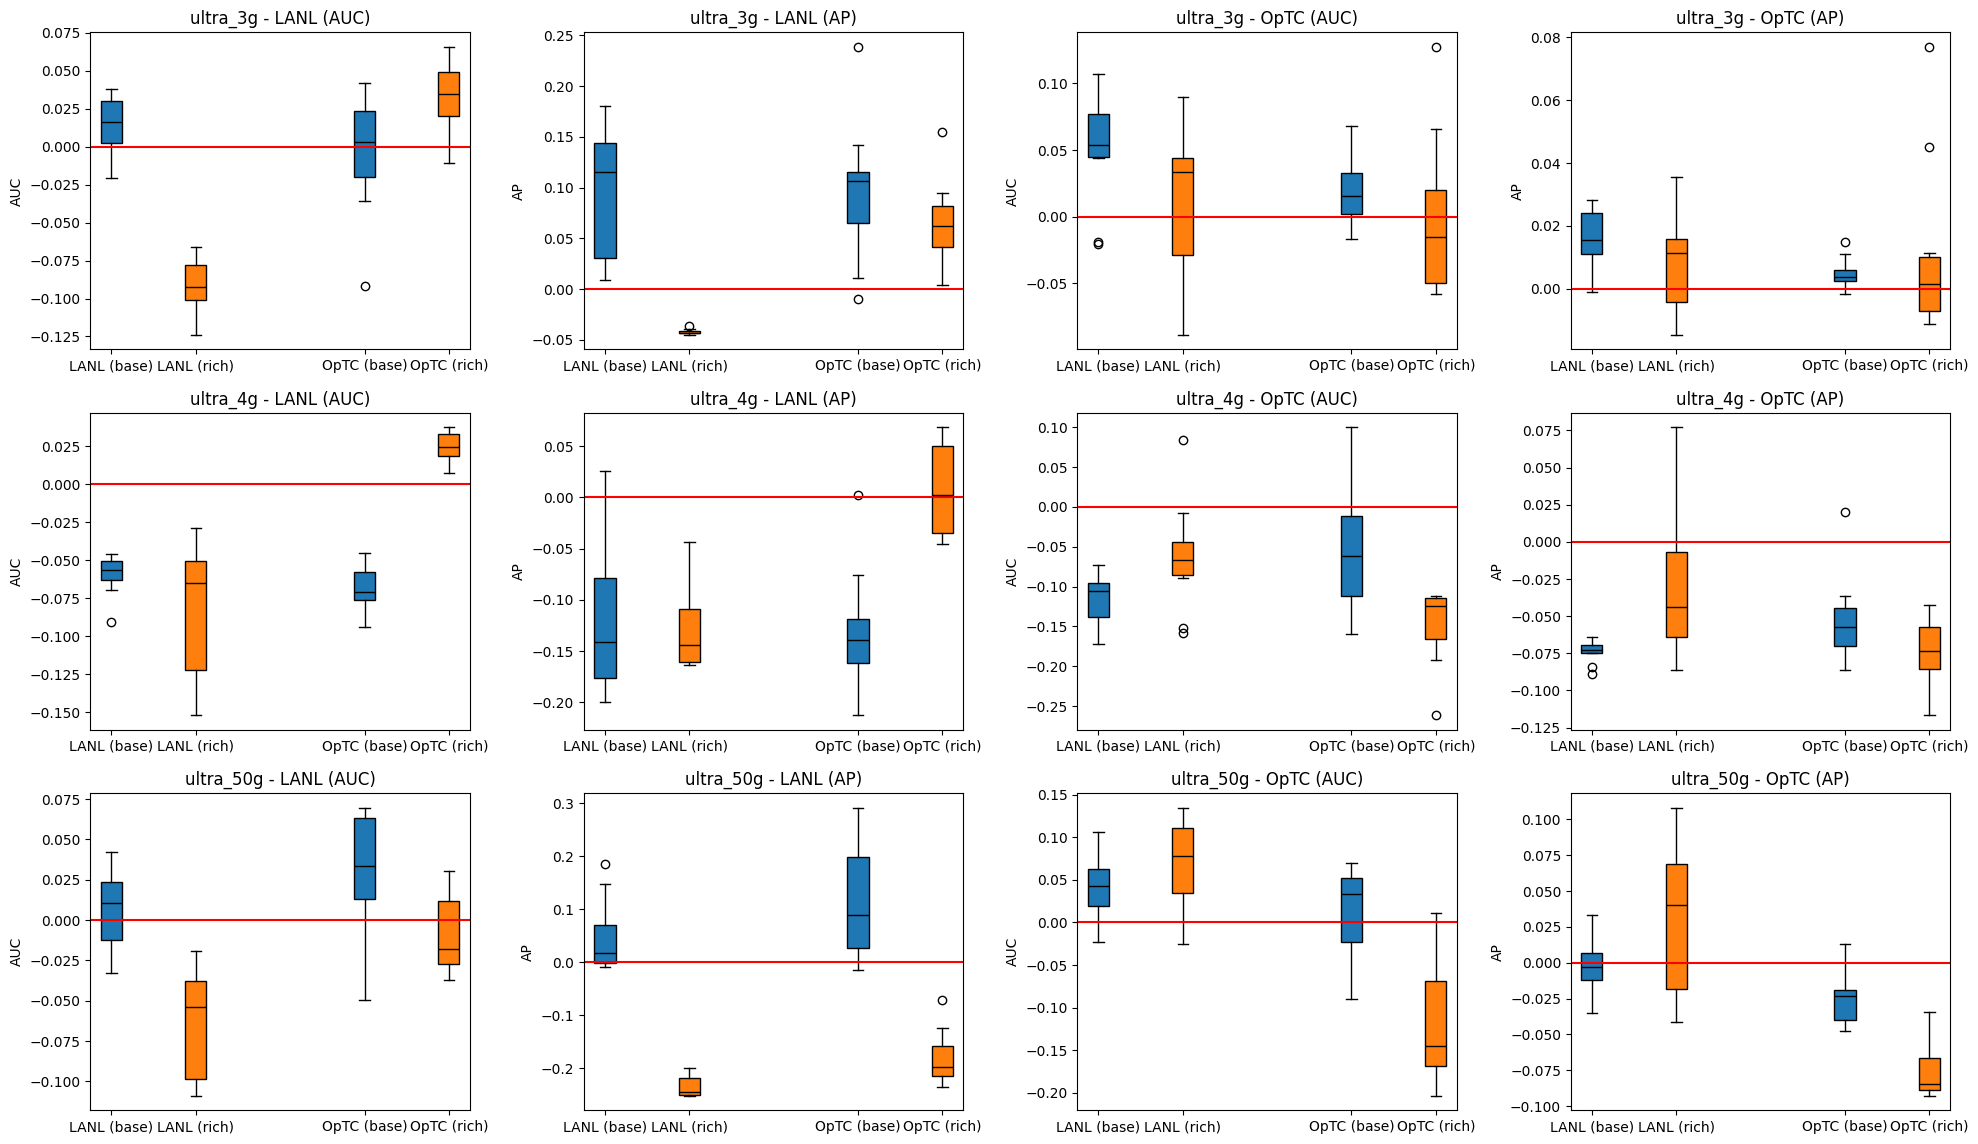

In [7]:
fig, axes = plt.subplots(3, 4)
models = ['ultra_3g', 'ultra_4g', 'ultra_50g']
for row, model in enumerate(models):
    for idx, dataset in enumerate(['lanl', 'optc']):
        for metric, ax in zip(['auc', 'ap'], axes[row, 2 * idx:2 * (idx + 1)]):
            bplot = ax.boxplot(
                [
                    np.array(res[dataset][model + ' (LANL)'][metric]) - res[dataset][model][metric][0],
                    np.array(res[dataset + '-rich'][model + ' (LANL)'][metric]) - res[dataset + '-rich'][model][metric][0],
                    np.array(res[dataset][model + ' (OpTC)'][metric]) - res[dataset][model][metric][0],
                    np.array(res[dataset + '-rich'][model + ' (OpTC)'][metric]) - res[dataset + '-rich'][model][metric][0]
                ],
                positions=[1, 3, 7, 9],
                labels=[f'{ft} ({rep})' for ft in ('LANL', 'OpTC') for rep in ('base', 'rich')],
                patch_artist=True
            )
            for patch, color in zip(bplot['boxes'], COLORS[:2] * 2):
                patch.set_facecolor(color)
            for line in bplot['medians']:
                line.set_color('black')
            ax.hlines(0, .5, 9.5, color='red')
            ax.set_title(f"{model} - {DATASETS[dataset]} ({metric.upper()})")
            ax.set_ylabel(f"{metric.upper()}")
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(24, 14)

Overall, fine-tuning yields contrasted results. In particular, neither fine-tuning on the dataset in which we seek to detect lateral movement nor fine-tuning on the other dataset leads to consistent improvement across all models and datasets. In addition, the variance across runs is often very high, which also suggests that fine-tuning brings no significant benefits. It is notable, however, that fine-tuning on the "other" dataset (the one not targeted for detection) globally works better than fine-tuning on the "same" dataset, especially when using the rich representation.

Finally, we study the performance of models trained from scratch, comparing it with the zero-shot performance of the pre-trained models. Once again, training a model from scratch involves some amount of randomness, so we display the results of 10 runs as a box plot.

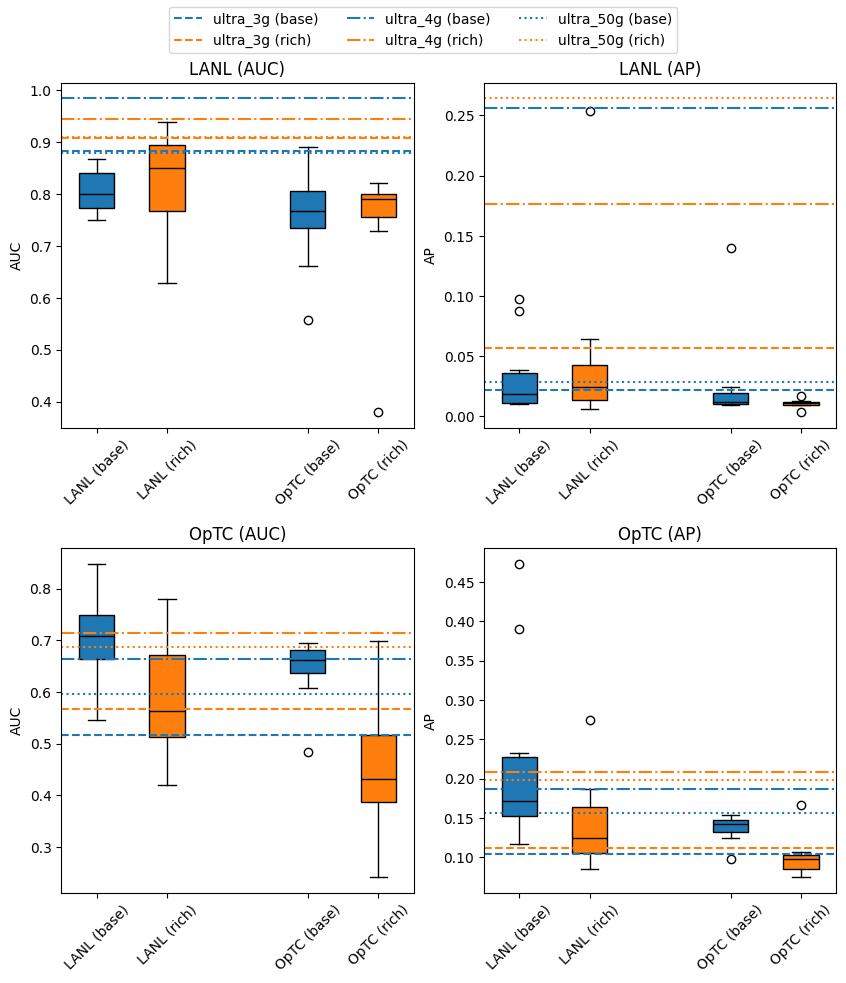

In [8]:
fig, axes = plt.subplots(2, 2)
for row, dataset in enumerate(['lanl', 'optc']):
    for metric, ax in zip(['auc', 'ap'], axes[row]):
        bplot = ax.boxplot(
            [
                res[dataset]['Ultra (LANL)'][metric],
                res[dataset + '-rich']['Ultra (LANL)'][metric],
                res[dataset]['Ultra (OpTC)'][metric],
                res[dataset + '-rich']['Ultra (OpTC)'][metric]
            ],
            positions=[1, 2, 4, 5],
            labels=['LANL (base)', 'LANL (rich)', 'OpTC (base)', 'OpTC (rich)'],
            patch_artist=True
        )
        for patch, color in zip(bplot['boxes'], COLORS[:2] * 2):
            patch.set_facecolor(color)
        for line in bplot['medians']:
            line.set_color('black')
        for model, ls in zip(['ultra_3g', 'ultra_4g', 'ultra_50g'], LINESTYLES[:3]):
            ax.hlines(
                res[dataset][model][metric][0],
                .5, 5.5,
                color=COLORS[0], ls=ls,
                label=f"{model} (base)"
            )
            ax.hlines(
                res[dataset + '-rich'][model][metric][0],
                .5, 5.5,
                color=COLORS[1], ls=ls,
                label=f"{model} (rich)"
            )
        ax.set_title(f"{DATASETS[dataset]} ({metric.upper()})")
        ax.set_ylabel(f"{metric.upper()}")
        ax.tick_params(axis='x', labelrotation=45)
        handles, labels = ax.get_legend_handles_labels()
plt.subplots_adjust(top=.92, hspace=.35)
fig.legend(handles, labels, ncol=3, loc='upper center')
fig.set_size_inches(10, 10)

The results are quite unequivocal: training from scratch on one lateral movement detection dataset is worse than pre-training on several knowledge graphs from other domains. Note that we used the exact same architecture as the pre-trained models, so it is possible that a smaller model (e.g., with less layers) could perform better. Another lead worth exploring is pre-training a new Ultra model on several cybersecurity-related datasets.